# Encoder

Each encoder layer contains:

1. Self-Attention:
    * Captures relationships within the sequence.
2. Feedforward Network (FFN):
    * Two linear layers with a ReLU/GELU activation in between.
3. Add & Normalize:
    * Residual connection and layer normalization.


<div style="text-align: center;">
    <img src="img/encoder.PNG" height="400px"/>
</div>

## Self-Attention

### Self-Attention Mechanism

Self-attention enables each token in the input sequence to attend to every other token in the sequence.

#### Step 1: Compute Three Vectors for Each Token
- **Query (𝑄)**: What the token wants to know.
- **Key (𝐾)**: How relevant a token is for answering.
- **Value (𝑉)**: The content of the token.

#### Step 2: Calculate Attention Scores
The attention score is computed as follows:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V
$$

Where:

- $softmax$ ensures the scores are normalized.
- $d_k$ is the scaling factor to stabilize gradients.


In [ ]:
import os
import sys
# Add the parent directory of `TransformerNNX` to the Python path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../..")))

In [22]:
import jax
import jax.numpy as jnp
from typing import Optional, Tuple, List
import matplotlib.pyplot as plt
from flax import nnx
from model import utils

In [9]:
def scaled_dot_product(
    q: jnp.ndarray, 
    k: jnp.ndarray, 
    v: jnp.ndarray, 
    mask: Optional[jnp.ndarray] = None,
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    Compute scaled dot-product attention.

    Args:
        q: Query tensor of shape (..., seq_len, d_k).
        k: Key tensor of shape (..., seq_len, d_k).
        v: Value tensor of shape (..., seq_len, d_k).
        mask: Optional mask tensor of shape (..., seq_len, seq_len).
    
    Returns:
        values: Tensor of shape (..., seq_len, d_k) containing the attention-weighted values.
        attention: Tensor of shape (..., seq_len, seq_len) containing attention scores.
    """
    d_k = q.shape[-1]  # Dimensionality of key vectors
    attn_logits = jnp.matmul(q, jnp.swapaxes(k, -2, -1))  # Compute attention logits
    attn_logits = attn_logits / jnp.sqrt(d_k)  # Scale by sqrt(d_k)

    if mask is not None:
        attn_logits = jnp.where(mask == 0, -1e9, attn_logits)  # Apply mask with large negative value

    attention = jax.nn.softmax(attn_logits, axis=-1)  # Softmax over last axis
    values = jnp.matmul(attention, v)  # Compute weighted values
    return values, attention



Output values shape: (1, 5, 4)
Attention shape: (1, 5, 5)


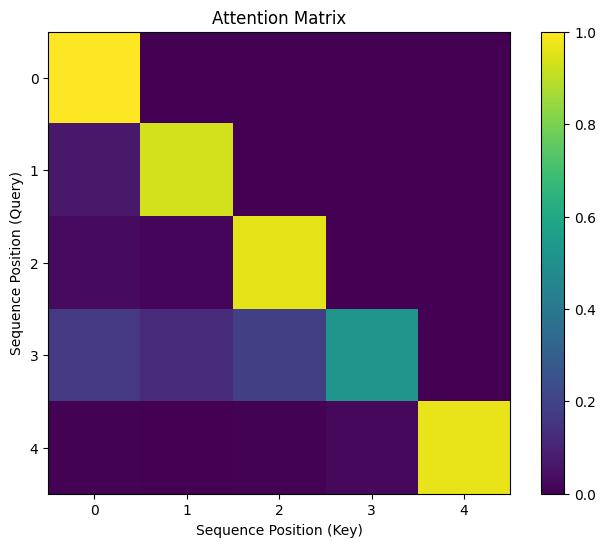

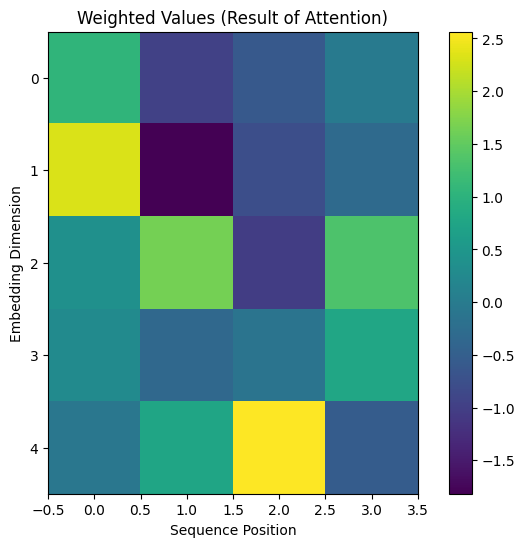

In [13]:
key = jax.random.PRNGKey(0)

# Define dimensions
seq_len = 5
d_k = 4  # Dimensionality of the key/query/value vectors

# Create random tensors for q, k, v
q = jax.random.normal(key, (1, seq_len, d_k))  # Query tensor of shape (1, seq_len, d_k)
k = jax.random.normal(key, (1, seq_len, d_k))  # Key tensor of shape (1, seq_len, d_k)
v = jax.random.normal(key, (1, seq_len, d_k))  # Value tensor of shape (1, seq_len, d_k)

# Optional mask encoding matrix
mask = jnp.tril(jnp.ones((seq_len, seq_len)), k=0)

# Test the function
values, attention = scaled_dot_product(q, k, v, mask=mask)

# Check the shape of the output
print(f"Output values shape: {values.shape}")
print(f"Attention shape: {attention.shape}")
plt.figure(figsize=(8, 6))
plt.imshow(attention[0], cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.title("Attention Matrix")
plt.xlabel("Sequence Position (Key)")
plt.ylabel("Sequence Position (Query)")
plt.show()

# Plot the values (weighted sum of value vectors)
plt.figure(figsize=(8, 6))
plt.imshow(values[0], cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.title("Weighted Values (Result of Attention)")
plt.xlabel("Sequence Position")
plt.ylabel("Embedding Dimension")
plt.show()

## Multi-Head Attention

Instead of using a single attention mechanism, **Multi-Head Attention** splits the query, key, and value vectors into multiple "heads":

1. Split $Q, K, V$ into multiple heads.
2. Perform attention for each head independently.
3. Concatenate the results and project back to the original model dimension.


In [23]:
class MultiHeadAttention(nnx.Module):
    """
    Implements a multi-head attention mechanism.

    Attributes:
    ----------
    qkv_projection : nnx.Linear
        Linear layer for projecting the input into query, key, and value tensors.
    out_projection : nnx.Linear
        Linear layer for projecting the output values back to the embedding dimension.

    Methods:
    -------
    __call__(x, num_heads, mask=None):
        Computes the multi-head attention output for the input tensor `x` with the given number of heads.
    """

    def __init__(self, 
                 embed_dim: int, 
                 num_heads:int, 
                 *, rngs: nnx.Rngs) -> None:
        """
        Initializes the MultiHeadAttention module.

        Parameters:
        ----------
        embed_dim : int
            The dimension of the input embeddings.
        num_heads : int
            The number of attention heads.
        rngs : nnx.Rngs
            Random number generators for initializing weights of the projection layers.
        """
        self.num_heads = num_heads
        self.qkv_projection = nnx.Linear(embed_dim, 3 * embed_dim, rngs=rngs)
        self.out_projection = nnx.Linear(embed_dim, embed_dim, rngs=rngs)
        

    def __call__(self, 
                 x: jnp.ndarray, 
                 mask: Optional[jnp.ndarray] = None,
                 ) -> Tuple[jnp.ndarray, jnp.ndarray]:
        """
        Applies the multi-head attention mechanism.

        Parameters:
        ----------
        x : jnp.ndarray
            Input tensor of shape `(batch_size, seq_len, embed_dim)`.
        mask : Optional[jnp.ndarray], default=None
            Optional mask tensor of shape `(batch_size, seq_len, seq_len)` 
            or `(batch_size, num_heads, seq_len, seq_len)` to apply attention masking.

        Returns:
        -------
        Tuple[jnp.ndarray, jnp.ndarray]
            - Output tensor of shape `(batch_size, seq_len, embed_dim)`.
            - Attention weights tensor of shape `(batch_size, num_heads, seq_len, seq_len)`.
        """
        batch_size, seq_len, embed_dim = x.shape
        if mask is not None:
            mask = utils.expand_mask(mask)  # Ensure mask is in the correct 4D format
        
        # Compute query, key, and value projections
        qkv = self.qkv_projection(x)  # Shape: (batch_size, seq_len, 3 * embed_dim)
        qkv = qkv.reshape(batch_size, seq_len, self.num_heads, -1)  # Split heads
        qkv = qkv.transpose(0, 2, 1, 3)  # Shape: (batch_size, num_heads, seq_len, d_k)
        q, k, v = jnp.array_split(qkv, 3, axis=-1)  # Split into query, key, value
        
        # Compute scaled dot-product attention
        values, attention = scaled_dot_product(q, k, v, mask)  # Custom function
        
        # Reshape and project output
        values = values.transpose(0, 2, 1, 3).reshape(batch_size, seq_len, -1)
        out = self.out_projection(values)
        
        return out, attention


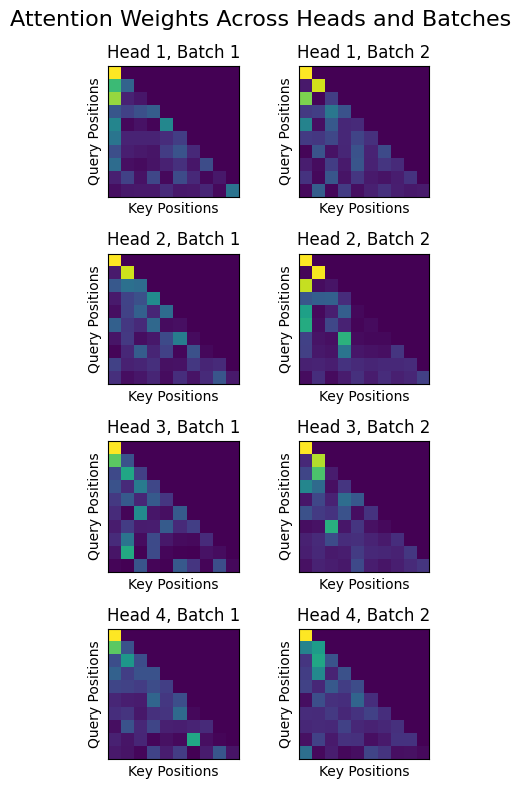

In [28]:
# Create synthetic data
batch_size = 2
seq_len = 10
embed_dim = 16
num_heads = 4

# Random inputs and mask
key = jax.random.PRNGKey(42)
x = jax.random.normal(key, (batch_size, seq_len, embed_dim))
mask = jnp.tril(jnp.ones((seq_len, seq_len)))  # Lower triangular mask

# Initialize MultiHeadAttention
rngs = nnx.Rngs(0)
mha = MultiHeadAttention(embed_dim, num_heads, rngs=rngs)

# Forward pass
output, attention = mha(x, mask=mask)

# Assert output shape
assert output.shape == (batch_size, seq_len, embed_dim)
assert attention.shape == (batch_size, num_heads, seq_len, seq_len)

# Plot attention weights for each head
fig, axes = plt.subplots(num_heads, batch_size, figsize=(4, 8))
fig.suptitle("Attention Weights Across Heads and Batches", fontsize=16)

for i in range(num_heads):
    for j in range(batch_size):
        ax = axes[i, j] if num_heads > 1 else axes[j]
        ax.matshow(attention[j, i], cmap="viridis")
        ax.set_title(f"Head {i + 1}, Batch {j + 1}")
        ax.set_xlabel("Key Positions")
        ax.set_ylabel("Query Positions")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()


## Encoder Block

The **Encoder Block** is a foundational component of the Transformer architecture, designed to efficiently model sequence-to-sequence relationships. It integrates **multi-head attention** and **feedforward layers** with residual connections, layer normalization, and dropout to ensure stability and robustness during training.


### Implementation
The encoder block starts with a multi-head attention mechanism followed by a feedforward network. Residual connections wrap around both components, and layer normalization ensures smooth gradient flow.

### Design Debate: Layer Norm Position
One of the most contentious design choices in the encoder block is the placement of **Layer Normalization**. 

#### Traditional Position (Post-Residual):
- In the original Transformer paper by Vaswani et al., layer normalization is applied *after* the residual connection. 
- **Why?**
  - Normalizing the combined output of the main path and residual path improves stability.
  - This placement assumes that residual connections should provide unaltered "backup" gradients during backpropagation.

#### Modern Position (Pre-Residual):
- Newer architectures like **T5** apply layer normalization *before* the residual connection.
- **Why the shift?**
  - Pre-norm stabilizes training for deeper models.
  - Makes gradient flow smoother, especially for large-scale training with many encoder blocks.
  - Avoids the need for additional scaling factors in residual connections.

In [29]:
class EncoderBlock(nnx.Module):
    """
    A single Transformer encoder block consisting of multi-head attention, feedforward layers, 
    layer normalization, and dropout.

    Attributes:
        mha (MultiHeadAttention): Multi-head attention mechanism.
        linear (list[nnx.Module]): A list of feedforward layers including two linear transformations and dropout.
        norm1 (nnx.LayerNorm): Layer normalization after the multi-head attention layer.
        norm2 (nnx.LayerNorm): Layer normalization after the feedforward layers.
        dropout (nnx.Dropout): Dropout layer applied after the multi-head attention and feedforward layers.
    
    Args:
        input_dim (int): Dimensionality of the input embeddings.
        feedforward_dim (int): Dimensionality of the intermediate feedforward layer.
        dropout_prob (float): Probability of dropout.
        num_heads (int): Number of attention heads.
        rngs (nnx.Rngs): Random number generators for reproducibility.
    """

    def __init__(self, 
                 input_dim: int, 
                 feedforward_dim: int, 
                 dropout_prob: float, 
                 num_heads: int,
                 *, rngs: nnx.Rngs):
        self.mha = MultiHeadAttention(input_dim, num_heads, rngs=rngs)
        self.linear = [
            nnx.Linear(input_dim, feedforward_dim, rngs=rngs),
            nnx.Dropout(dropout_prob, rngs=rngs),
            nnx.Linear(feedforward_dim, input_dim, rngs=rngs),
        ]
        self.norm1 = nnx.LayerNorm(input_dim, rngs=rngs)
        self.norm2 = nnx.LayerNorm(input_dim, rngs=rngs)
        self.dropout = nnx.Dropout(dropout_prob, rngs=rngs)

    def __call__(self, 
                 x: jnp.ndarray, 
                 mask: Optional[jnp.ndarray] = None
                 ) -> jnp.ndarray:
        """
        Forward pass for the Transformer encoder block.

        Args:
            x (jnp.ndarray): Input tensor of shape (batch_size, seq_len, input_dim).
            mask (Optional[jnp.ndarray]): Optional attention mask of shape 
                                          (seq_len, seq_len), 
                                          (batch_size, seq_len, seq_len), 
                                          or (batch_size, num_heads, seq_len, seq_len).

        Returns:
            jnp.ndarray: Output tensor of shape (batch_size, seq_len, input_dim).
        """
        # Multi-Head Attention with residual connection and layer norm
        mha_out, _ = self.mha(x, mask=mask)
        x = x + self.dropout(mha_out)
        x = self.norm1(x)
        
        # Feedforward network with residual connection and layer norm
        linear_out = x
        for l in self.linear:
            linear_out = l(linear_out)
        linear_out = nnx.gelu(linear_out)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)
        return x

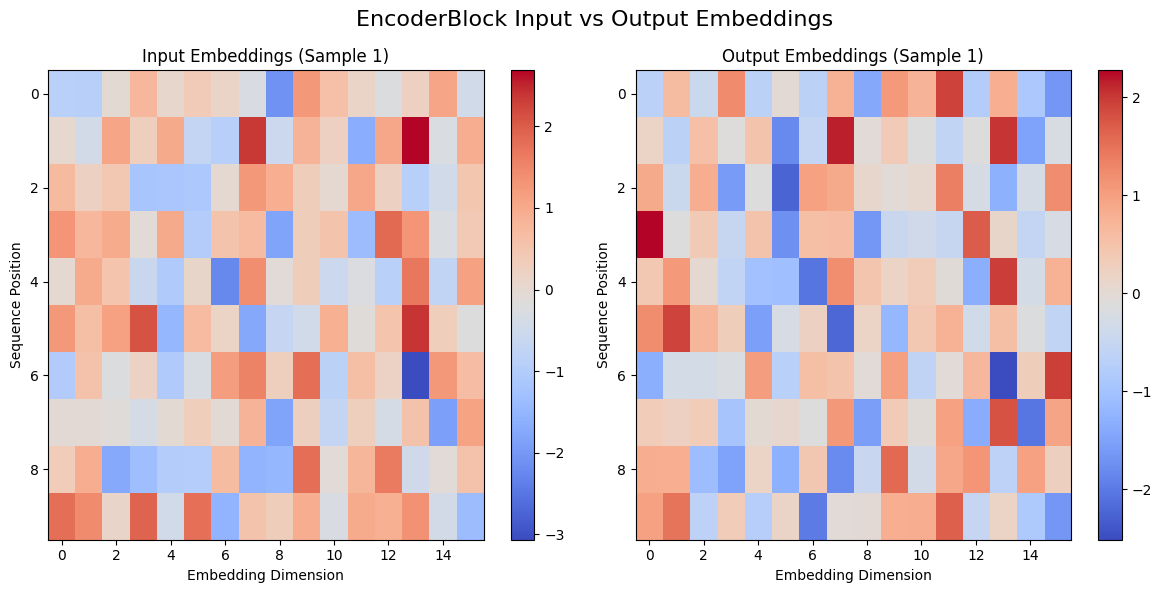

In [30]:
# Define the EncoderBlock test parameters
batch_size = 2
seq_len = 10
input_dim = 16
feedforward_dim = 64
dropout_prob = 0.1
num_heads = 4

# Create random input data and mask
key = jax.random.PRNGKey(42)
x = jax.random.normal(key, (batch_size, seq_len, input_dim))
mask = jnp.tril(jnp.ones((seq_len, seq_len)))  # Lower triangular mask

# Initialize EncoderBlock
rngs = nnx.Rngs(key)
encoder_block = EncoderBlock(input_dim, feedforward_dim, dropout_prob, num_heads, rngs=rngs)

# Forward pass
output = encoder_block(x, mask=mask)

# Assert the output shape
assert output.shape == (batch_size, seq_len, input_dim), "Output shape mismatch."

# Visualize the input and output embeddings for one sample
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("EncoderBlock Input vs Output Embeddings", fontsize=16)

# Input Embeddings
axes[0].imshow(x[0], aspect="auto", cmap="coolwarm")
axes[0].set_title("Input Embeddings (Sample 1)")
axes[0].set_xlabel("Embedding Dimension")
axes[0].set_ylabel("Sequence Position")
axes[0].colorbar = plt.colorbar(axes[0].imshow(x[0], aspect="auto", cmap="coolwarm"), ax=axes[0])

# Output Embeddings
axes[1].imshow(output[0], aspect="auto", cmap="coolwarm")
axes[1].set_title("Output Embeddings (Sample 1)")
axes[1].set_xlabel("Embedding Dimension")
axes[1].set_ylabel("Sequence Position")
axes[1].colorbar = plt.colorbar(axes[1].imshow(output[0], aspect="auto", cmap="coolwarm"), ax=axes[1])

plt.tight_layout()
plt.show()
